* Moneyball – The Portland Sea Dogs have awarded the venerable firm of Girsch &
Rosenthal Data Analytics, a contract to determine which is the most important baseball
statistic to determine how successful a team will be. As an employee of the firm you will
perform the following analysis and gather your results into a presentation to be given to the
Sea Dog’s management.

* 1). Using the data file for an MLB team’s hitting statistics determine the correlation
coefficient for each of the following On Base Percentage (OBP) , Slugging Percentage (SLG) ,
Batting Average (AVG), Runs Batted In (RBI) with Winning Percentage (WPCT). Using the data
file for MLB team’s pitching statistics determine the correlation coefficient for each of the
following Earned Run Average (ERA) , Number of Strikeouts (SO) , Runs given up (R), Home
Runs Given UP (HR) with Winning Percentage (WPCT). Put all your results into a table

* 2). Using the batting statistic with the highest correlation to winning percentage make a least
squares linear model to predict winning percentage from this statistic. Do the same for the
pitching statistic with the highest correlation. Produce plots showing the raw data, the least
squares line for each of the fits and the two s error bars. Remove any outliers that may occur
and refit the data. Test for outliers at the 95% level (n = 2)

* 3). Compute the RMSE for each of the fits.

* 4). Make a final argument in your presentation for whether hitting or pitching is the most
important

In [1]:
import seaborn as sb
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def mean(data):
    sum = 0
    for val in data:
        sum += val
    average = sum/len(data)
    return average

def variance(data):
    sum = 0
    for num in data:
        sum += (num - mean(data))**2
    vari = sum/len(data)
    return vari

def stand_dev(data):
    de = math.sqrt(variance(data))
    return de

def correlation_array(array1, array2):
    x_sum = np.sum(array1)
    y_sum = np.sum(array2)
    e1 = np.sum(np.multiply(array1, array2))
    x_sq = np.sum(np.power(array1, 2))
    y_sq = np.sum(np.power(array2,2))
    
    e1 = e1*len(array1)

    x_sq_sub = (x_sq *len(array1)) - x_sum**2
    x_sqed = math.sqrt(x_sq_sub)
    
    y_sq_sub = (y_sq * len(array2)) - y_sum**2
    y_sqed = math.sqrt(y_sq_sub)
    
    top = e1 - (x_sum * y_sum)
    bottom = x_sqed*y_sqed
    
    corr = top / bottom
    
    return corr

def least_squares_array(array1, array2):
    x_sq = np.sum(np.power(array1, 2))
    x_sum = np.sum(array1)
    xy_sum = np.sum(np.multiply(array1, array2))
    y_sum = np.sum(array2)
    
    array_reg = np.array([[x_sq, x_sum], [x_sum, len(array1)]])
    array_2 = np.array([xy_sum, y_sum])
    array_inverse = np.linalg.inv(array_reg)
    answer = np.dot(array_inverse, array_2)
    return answer

def line_graph(x_list, y_list, x_label = None, y_label = None, amount=1, colour='blue', mark="o", line='-'):
    '''amount is number of lines on a graph. if the amount is greater than one, submit lists of lists for the other three paramters. ex: amount=1, x_list=[1,2,3] or amount=2, x_list=[[1,2,3],[4,5,6]]'''
    if amount >1:
        for num in range(0, amount):
            plt.plot(x_list[num], y_list[num], color=colour[num], marker=mark[num], linestyle=line[num])
    else:
        plt.plot(x_list, y_list, color=colour, marker=mark, linestyle=line)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def slope_to_points(slope, intercept, point_nums):
    list_x = []
    list_y = []
    for num in point_nums:
        list_x.append(num)
        y_point = slope * num + intercept
        list_y.append(y_point)
    return list_x, list_y

def residuals(x_list, y_list, slope, intercept):
    res_list = []

    for item in range(0,len(x_list)):
        res = y_list.iloc[item] - (slope * x_list.iloc[item] + intercept)
        res_list.append(res)
        
    res_mean = mean(res_list)
    res_deviation = stand_dev(res_list)
    
    return res_list, res_mean, res_deviation

def outlier_finder(x, y, n, dev_list, mean, deviation):
    outliers = []
    for num in range(0,len(dev_list)):
        if dev_list[num] > mean + n*deviation:
            outliers.append(dev_list[num])
        elif dev_list[num] < mean - n*deviation:
            outliers.append(dev_list[num])
        else:
            continue
    for item in outliers:
        x.drop(dev_list.index(item), axis=0)
        y.drop(dev_list.index(item), axis=0)
        dev_list.remove(item)
            
    return x, y

def rmse(y, least_y):
    sum = 0
    for num in range(0,len(y)):
        sum += (y.iloc[num]-least_y[num])**2
    sum = sum/2
    final = np.sqrt(sum)
    return final

def old_vs_new_plot(x, y, x_title, y_title):
    data_slope, data_intercept = least_squares_array(x,y)
    data_r, data_rmean, data_rdev = residuals(x,y,data_slope, data_intercept)
    new_x, new_y = outlier_finder(x,y,confidence,data_r, data_rmean, data_rdev)

    fit_slope, fit_intercept = least_squares_array(new_x, new_y)
    fit_data_r, fit_data_rmean, fit_data_rdev = residuals(new_x,new_y,fit_slope, fit_intercept)
    fit_xs, fit_ys = slope_to_points(fit_slope, fit_intercept, new_x)
    fit_ubx, fit_uby = slope_to_points(fit_slope, fit_intercept + (fit_data_rmean + confidence * fit_data_rdev), new_x)
    fit_lbx, fit_lby = slope_to_points(fit_slope, fit_intercept - (fit_data_rmean + confidence * fit_data_rdev), new_x)

    error = rmse(y, fit_ys)
    
    line_graph([x,fit_xs, fit_ubx, fit_lbx], [y,fit_ys, fit_uby, fit_lby], x_label = x_title, y_label = y_title, amount=4, colour=["green", "blue", "red", "red"], mark=["*", "", "", ""], line=["", "-", "--", "--"])
    return error

In [3]:
path_pitch = "/kaggle/input/pitching/2018_MLB_Pitching_Stats_II.txt"
pitch=pd.read_csv(path_pitch, delim_whitespace = True)


path_hit = "/kaggle/input/hitting/2018_MLB_Hitting_Stats.txt"
hitting = pd.read_csv(path_hit, delim_whitespace=True)
hitting.head()

,#,Team,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,SO,BB,AVG,OBP,SLG,OPS,WPCT
0,1,Indians_Cleveland,162,6300,5595,818,1447,297,19,216,786,135,36,1189,522,0.259,0.332,0.434,0.766,0.562
1,2,Rays_Tampa_Bay,162,6195,5475,716,1415,274,43,150,664,128,51,1388,523,0.258,0.333,0.406,0.739,0.556
2,3,Red_Sox_Boston,162,6302,5623,876,1509,355,31,208,829,125,31,1253,531,0.268,0.339,0.453,0.792,0.667
3,4,Brewers_Milwaukee,163,6210,5542,754,1398,252,24,218,711,124,32,1458,505,0.252,0.323,0.424,0.747,0.589
4,5,Nationals_Washington,162,6288,5517,771,1402,284,25,191,737,119,33,1289,575,0.254,0.335,0.419,0.754,0.506


In [4]:
pitch.head()

,#,Team,G,IP,H,ER,HR,BB,SO,WHIP,H/9,BB/9,HR/9,SO/9,SO/BB,GB/FB,HR/FB,ERC,ERA,WPCT
0,1,Orioles_Baltimore,162,1431.0,1552,825,234,589,1203,1.50,9.8,3.7,1.5,7.6,2.15,1.83,0.222,5.26,5.19,0.290
1,2,Royals_Kansas_City,162,1432.0,1542,787,205,549,1157,1.46,9.7,3.5,1.3,7.3,2.22,1.90,0.196,4.89,4.95,0.358
2,3,Rangers_Texas,162,1431.0,1516,783,222,491,1121,1.40,9.5,3.1,1.4,7.0,2.40,1.86,0.207,4.77,4.93,0.414
3,4,Reds_Cincinnati,162,1441.0,1491,745,228,532,1258,1.40,9.3,3.3,1.4,7.9,2.67,2.08,0.232,4.63,4.65,0.414
4,5,Blue_Jays_Toronto,162,1433.2,1476,773,208,551,1298,1.41,9.3,3.5,1.3,8.1,2.44,1.76,0.193,4.67,4.85,0.451


In [5]:
#On Base Percentage (OBP) , Slugging Percentage (SLG) , Batting Average (AVG), Runs Batted In (RBI) with Winning Percentage (WPCT)
hit_columns = ["OBP", "SLG", "AVG", "RBI"]
hit_dict = {"":["Hitting"]}
for column in hit_columns:
    hit_dict[column]=(correlation_array(hitting[column],hitting["WPCT"]))
hit_pd = pd.DataFrame.from_dict(hit_dict)

#Earned Run Average (ERA) , Number of Strikeouts (SO) , Runs given up (R), Home Runs Given UP (HR) with Winning Percentage (WPCT)
pitch_columns = ["ERA", "SO", "ER", "HR"]
pitch_dict = {"":["Pitching"]}
for column in pitch_columns:
    pitch_dict[column]=(correlation_array(pitch[column],pitch["WPCT"]))
pitch_pd = pd.DataFrame.from_dict(pitch_dict)
pitch_pd

,,ERA,SO,ER,HR
0,Pitching,-0.875797,0.736197,-0.874808,-0.656634


In [6]:
hit_pd
#pitch_pd and hit_pd are the correlations for each column title vs win percentage

,,OBP,SLG,AVG,RBI
0,Hitting,0.798343,0.749826,0.68859,0.823533


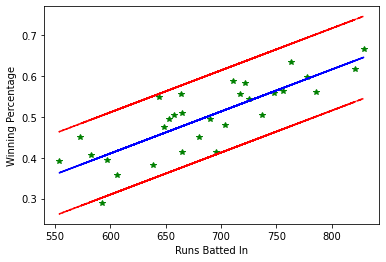

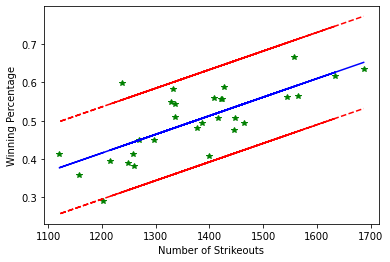

0.19520284406359478
0.23288260227162635


In [7]:
confidence = 2

#hit
hit_er = old_vs_new_plot(hitting["RBI"], hitting["WPCT"], "Runs Batted In", "Winning Percentage")
#pitch
pitch_er = old_vs_new_plot(pitch["SO"], pitch["WPCT"], "Number of Strikeouts", "Winning Percentage")
print(f"{hit_er}\n{pitch_er}")

<AxesSubplot:>

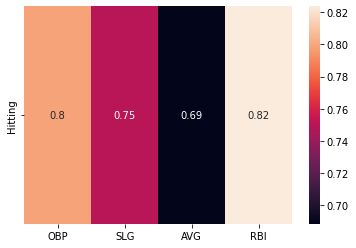

In [8]:
sb.heatmap((hit_pd.drop([""], axis=1)),  annot=True, yticklabels=hit_pd[''])

<AxesSubplot:>

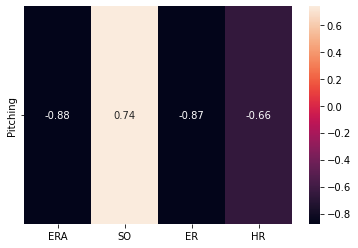

In [9]:
sb.heatmap((pitch_pd.drop([""], axis=1)),  annot=True, yticklabels=pitch_pd[''])